<a href="https://colab.research.google.com/github/huerd/GPA659-E2020/blob/mobileNetOutputs/_project/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### *Resources*

### Visualisations
*   Image Files to Numpy Array : https://www.kaggle.com/lgmoneda/from-image-files-to-numpy-arrays
*   MobileNetV2 Dogs/Cats implementation : https://www.kaggle.com/abdallahhassan/dogs-cats-mobilenetv2-transfere-learning









# Runtime Setup : Authorization w/ Kaggle database and download

1.   Set your Kaggle API .JSON file to this runtime
2.   Downloads and extract dogs-vs-cats.zip into two folders
3.   Installs/replaces other programs



In [ ]:
# updates kaggle version
!pip install pillow==7.0.0 
!pip install --upgrade --force-reinstall --no-deps kaggle

# fix https://github.com/keras-team/keras-preprocessing/issues/116 for datagen
!pip uninstall -y keras-preprocessing
!pip install git+https://github.com/keras-team/keras-preprocessing.git

from google.colab import files
import zipfile

# select your Kaggle API kaggle.json
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

# make sure to create a kaggle account, get it verified (phone number and all)
# then go accept terms here : https://www.kaggle.com/c/dogs-vs-cats

# zip should be downloaded to /content/
!kaggle competitions download -c dogs-vs-cats
unzipMaster = zipfile.ZipFile("dogs-vs-cats.zip", 'r')
unzipMaster.extractall()
unzipMaster.close()

# don't expand the folders unless you want colab to crash on you
# file format is 1.jpg, 2.jpg, etc
unzipTest1 = zipfile.ZipFile("test1.zip", 'r')
unzipTest1.extractall()
unzipTest1.close()

# file format is cat.0.jpg, dog.2.jpg, etc
unzipTrain1 = zipfile.ZipFile("train.zip", 'r')
unzipTrain1.extractall()
unzipTrain1.close()

     |████████████████████████████████| 61kB 3.5MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.6-cp36-none-any.whl size=72859 sha256=564c166f2dd6e4f289a8e69e7910004a125e9025f883a4c45286b9ff80b1bb4c
  Stored in directory: /root/.cache/pip/wheels/57/4e/e8/bb28d035162fb8f17f8ca5d42c3230e284c6aa565b42b72674
Successfully built kaggle
  Found existing installation: kaggle 1.5.6
    Uninstalling kaggle-1.5.6:
      Successfully uninstalled kaggle-1.5.6
Uninstalling Keras-Preprocessing-1.1.2:
  Successfully uninstalled Keras-Preprocessing-1.1.2
  Cloning https://github.com/keras-team/keras-preprocessing.git to /tmp/pip-req-build-b34ihgp2
  Running command git clone -q https://github.com/keras-team/keras-preprocessing.git /tmp/pip-req-build-b34ihgp2
  Created wheel for Keras-Preprocessing: filename=Keras_Preprocessing-1.1.2-cp36-none-any.whl size=42983 sha256=742c79e78388fd3aa0525d7a78b8b24d37c7d1274bc4e2c224b405cbe10da4ea
  Stored in directory: /tmp/pip-ephem-wheel-cache-420sw_n7/wheels

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 69 bytes
 97% 788M/812M [00:03<00:00, 248MB/s]
100% 812M/812M [00:03<00:00, 213MB/s]


# Dev Environment Setup

In [ ]:
from __future__ import print_function

# uncomment below to use version 1.x
#%tensorflow_version 1.x
import tensorflow as tf
import keras.backend as K

from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from keras.applications import mobilenet, MobileNetV2
from keras.models import Model, Sequential
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.layers import Input, Dense, Conv2D, Conv3D, DepthwiseConv2D, SeparableConv2D, Conv3DTranspose
from keras.layers import Flatten, MaxPool2D, AvgPool2D, GlobalAvgPool2D, UpSampling2D, BatchNormalization
from keras.layers import Concatenate, Add, Dropout, ReLU, Lambda, Activation, LeakyReLU, PReLU

from scipy import ndimage
import matplotlib.pyplot as plt
import pandas
import numpy
import os, sys
import IPython.display
import PIL.Image
import random
import seaborn as sns
sns.set()

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Constants

In [ ]:
# both wxl must be minimum 32. Larger = longer training time.
IMAGE_WIDTH = 150
IMAGE_LENGTH = 150
IMAGE_SIZE = [IMAGE_WIDTH, IMAGE_LENGTH]
IMAGE_NUMCHANNELS = 3

TRAINING_SAMPLES = 8000
TRAININGDATASPLIT_RATIO = 0.9
BATCH_SIZE = 4
SEED = 4

QUICK_TRAIN = False
EPOCH_QUICK = 1
EPOCH_NORMAL = 15


# Data Preperation

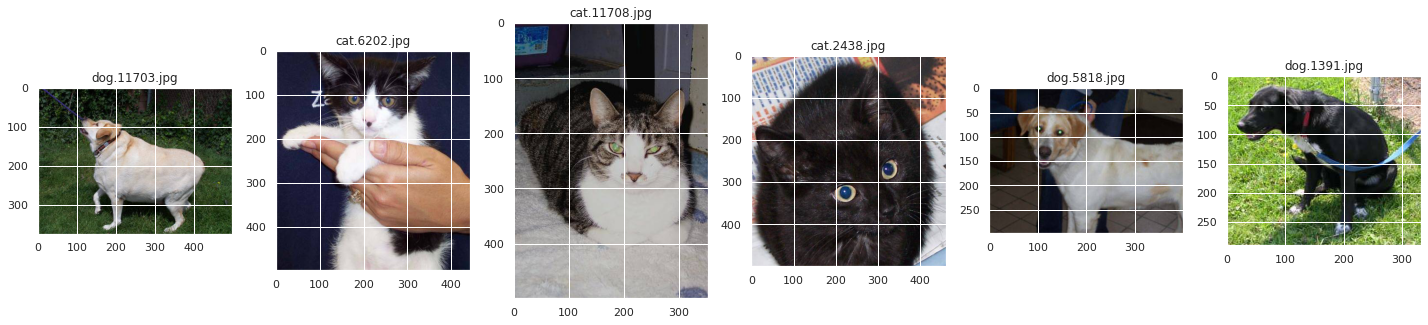

Total Counts from Labeled Data


dog    12500
cat    12500
Name: petType, dtype: int64

In [ ]:
trainingData_dir = "train/"
testingData_dir = "test1/"
imageOuputs_dir = "imageOutputs/"

# load data
labeledDataset = os.listdir(trainingData_dir)
testingDataset = os.listdir(testingData_dir)

results = []

# loop through our labeledDataset, one file at a time
for eachImage in labeledDataset:
  # recall that our labeledDataset file format is [animal].[num].jpg
  petType = eachImage.split('.')[0]
  if petType == 'cat':
    results.append("cat")
  else:
    results.append("dog")

# df_labeled is where all our labeled data is stored in a DataFrame
df_labeled = pandas.DataFrame({
    'imageName': labeledDataset,
    'petType': results
})

## Visualizations
# create figure size
plt.figure(figsize=(20, 12))
for i in range(0, 6):
    plt.subplot(1, 6, i+1)
    imageName = random.choice(labeledDataset)
    image = load_img(trainingData_dir + imageName)
    plt.title(imageName)
    plt.imshow(image)
plt.tight_layout()
plt.show()

print("Total Counts from Labeled Data")
df_labeled['petType'].value_counts()

## Training Data allocation

We ratio the labeled training data into two sets
* Data used to train our model (training data)
* Data used to validate our model (validation data)

In [ ]:
from sklearn.model_selection import train_test_split

# split your labeled dataset into training and validation sets based on a ratio
# if train_size is 0.3, then training is 70% of the dataset
df_training, df_validation = train_test_split(df_labeled, train_size = TRAININGDATASPLIT_RATIO)

# pandas.DataFrame.shape is a tuple
# https://www.programiz.com/python-programming/methods/tuple
total_dfTraining = df_training.shape[0]
total_dfValidation = df_validation.shape[0]


print("Labeled Data Allocation")
fmt = '{:<4} {:<2} {:<15} '
print(fmt.format("Train :", "", total_dfTraining))
print(fmt.format("Valid :", "", total_dfValidation))

# ref https://github.com/IResearchAI/Tobacco_Leaves_Classification_CNN/blob/master/Tob_main1.ipynb

Labeled Data Allocation
Train :    22500           
Valid :    2500            


## Preprocessing - Data Augmentation

Data Augmentation is used to apply various transforms to existing labeled
data to increase data diversity, without having to gather new data.

* Keras' [ImageDataPrerocessing](https://keras.io/api/preprocessing/image/) API
*   https://www.pyimagesearch.com/2019/07/08/keras-imagedatagenerator-and-data-augmentation/
*   https://colab.research.google.com/github/google/eng-edu/blob/master/ml/pc/exercises/image_classification_part2.ipynb

*   [In-depth on Data Augmentation](https://medium.com/mlait/image-data-augmentation-image-processing-in-tensorflow-part-2-b77237256df0)

*  [Image Classification using data generators](https://mc.ai/tutorial-image-classification-with-keras-flow_from_directory-and-generators/)




Training Data Augmentation

Found 22500 validated image filenames belonging to 2 classes.
Visualized Example of Generator.


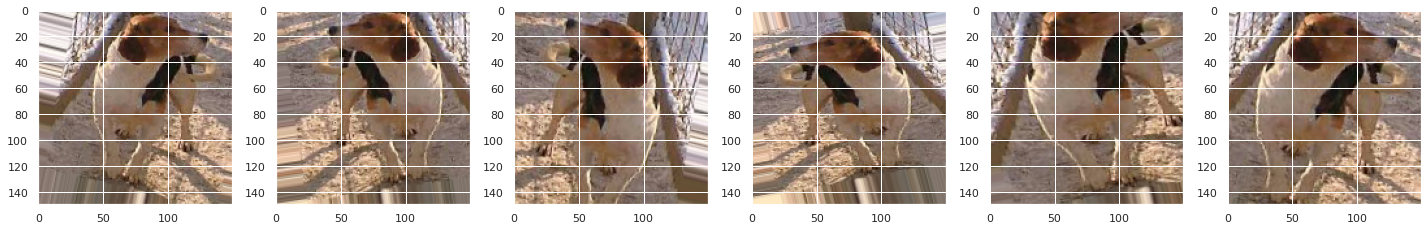

In [ ]:
# playing around here I guess
dg_training = ImageDataGenerator(
    rotation_range = 15,
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip= True,
    fill_mode = 'nearest',
    width_shift_range = 0.1,
    height_shift_range = 0.1
)

# Returns 
# A DataFrameIterator yielding tuples of (x, y) where x is a numpy array 
# containing a batch of images with shape (batch_size, *target_size, channels) 
# and y is a numpy array of corresponding labels.

train_generator = dg_training.flow_from_dataframe(
    df_training, 
    directory = trainingData_dir, 
    x_col = 'imageName',
    y_col = 'petType',
    # class_mode = 'binary',
    class_mode = 'categorical',
    target_size = (IMAGE_WIDTH, IMAGE_LENGTH),
    batch_size = BATCH_SIZE,
    seed = SEED
)

print("Visualized Example of Generator.")
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 6, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

# TODO have it return random images ?
augmented_images = [train_generator[0][0][0] for i in range(6)]
plotImages(augmented_images)

Validation Data Augmentation

In [ ]:
# same stuff but for validation data
# playing around here I guess
dg_validation = ImageDataGenerator(
    rotation_range = 15,
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip= True,
    fill_mode = 'nearest',
    width_shift_range = 0.1,
    height_shift_range = 0.1
)

# https://gist.github.com/RyanAkilos/3808c17f79e77c4117de35aa68447045
# shuffle = off

valid_generator = dg_validation.flow_from_dataframe(
    df_validation, 
    directory = trainingData_dir, 
    x_col = 'imageName',
    y_col = 'petType',
    # class_mode = 'binary',
    class_mode = 'categorical',
    target_size = (IMAGE_WIDTH, IMAGE_LENGTH),
    batch_size = BATCH_SIZE,
    shuffle = False,
    seed = SEED
)

Found 2500 validated image filenames belonging to 2 classes.


# Model Architecture


*   [MobileNet from scratch](https://github.com/IResearchAI/Tobacco_Leaves_Classification_CNN/blob/master/Tob_main2.ipynb)

In [ ]:
# mobile = keras.applications.mobilenet.MobileNet()

# Implementation from https://github.com/IResearchAI/Tobacco_Leaves_Classification_CNN/blob/master/Tob_main5.ipynb

  
def mobilenet_block(x, f, s=1):
  x = DepthwiseConv2D(3, strides=s, padding='same')(x)
  x = BatchNormalization()(x)
  x = ReLU()(x)
  
  x = Conv2D(f, 1, strides=1, padding='same')(x)
  x = BatchNormalization()(x)
  x = ReLU()(x)
  return x

    input = Input(inputImage)


def mobileNetImplementation(input, totalClasses):

  # LAYER 1 first 3x3 convolutional layer
  x = Conv2D(32, 3, strides=2, padding='same')(input)
  x = BatchNormalization()(x)
  x = ReLU()(x) # 32

  # LAYER 2 : depthwise 3x3     x32/s1
  x = DepthwiseConv2D(3, strides=1, padding='same')(x)
  x = BatchNormalization()(x)
  x = ReLU()(x) # 32

  # LAYER 3 : pointwise 1x1 x32   x64/s1
  x = Conv2D(64, 1, strides=1, padding='same')(x)
  x = BatchNormalization()(x)
  x = ReLU()(x) # 64

  # LAYER 4 : depthwise 3x3     x64/s2
  x = DepthwiseConv2D(3, strides=2, padding='same')(x)
  x = BatchNormalization()(x)
  x = ReLU()(x) # 64

  # LAYER 5 : pointwise 1x1 x64   x128/s1
  x = Conv2D(128, 1, strides=1, padding='same')(x)
  x = BatchNormalization()(x)
  x = ReLU()(x) # 128

  # LAYER 6 : depthwise 3x3     x128/s1
  x = DepthwiseConv2D(3, strides=1, padding='same')(x)
  x = BatchNormalization()(x)
  x = ReLU()(x) # 128

  # LAYER 7 : pointwise 1x1 x128   x128/s1
  x = Conv2D(128, 1, strides=1, padding='same')(x)
  x = BatchNormalization()(x)
  x = ReLU()(x) # 128

  # LAYER 8 : depthwise 3x3     x128/s2
  x = DepthwiseConv2D(3, strides=2, padding='same')(x)
  x = BatchNormalization()(x)
  x = ReLU()(x) # 128

  # LAYER 9 : pointwise 1x1 x128   x256/s1
  x = Conv2D(256, 1, strides=1, padding='same')(x)
  x = BatchNormalization()(x)
  x = ReLU()(x) # 256

  # LAYER 10 : depthwise 3x3     x256 /s1
  x = DepthwiseConv2D(3, strides= 1 , padding='same')(x)
  x = BatchNormalization()(x)
  x = ReLU()(x) # 256

  # LAYER 11 : pointwise 1x1 x 256   x 256 /s1
  x = Conv2D(256, 1, strides=1, padding='same')(x)
  x = BatchNormalization()(x)
  x = ReLU()(x) # 256

  # LAYER 12 : depthwise 3x3     x256 /s 2
  x = DepthwiseConv2D(3, strides= 2 , padding='same')(x)
  x = BatchNormalization()(x)
  x = ReLU()(x) # 256

  # LAYER 13 : pointwise 1x1 x 256   x 512 /s1
  x = Conv2D( 512 , 1, strides=1, padding='same')(x)
  x = BatchNormalization()(x)
  x = ReLU()(x) # 512

  # LAYER 14,15,16,17,18
  for currentLayer in range(5):
    # depthwise 3x3     X 512  /s 1
    x = DepthwiseConv2D(3, strides= 1 , padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x) # 512

    # pointwise 1x1 x 512   x 512 /s1
    x = Conv2D( 512 , 1, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x) # 512

  # LAYER 19 : depthwise 3x3     x 512 /s 2
  x = DepthwiseConv2D(3, strides= 2 , padding='same')(x)
  x = BatchNormalization()(x)
  x = ReLU()(x) # 512

  # LAYER 20 : pointwise 1x1 x 512   x 1024 /s1
  x = Conv2D( 1024 , 1, strides=1, padding='same')(x)
  x = BatchNormalization()(x)
  x = ReLU()(x) # 1024

  # LAYER 21 : depthwise 3x3     x1024 /s 2
  x = DepthwiseConv2D(3, strides= 2 , padding='same')(x)
  x = BatchNormalization()(x)
  x = ReLU()(x) # 1024

  # LAYER 22 : pointwise 1x1 x 1024   x 1024 /s1
  x = Conv2D( 1024 , 1, strides=1, padding='same')(x)
  x = BatchNormalization()(x)
  x = ReLU()(x) # 1024
  
  # LAYER 23 - avg pooling
  x = GlobalAvgPool2D()(x)
  
  # LAYER 24 + 25- FC/1 and softmax
  outputMobileNet = Dense(totalClasses, activation='softmax')(x)

  return outputMobileNet # inject into Model() function



We want to [adjust learning rate](https://machinelearningmastery.com/learning-rate-for-deep-learning-neural-networks/) when accuracy reaches certain thresholds.

By using [stochastic gradient descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) algoritm, it estimates the error gradient for the current training model and updates the weights using backpropagation.

API CALLS

* Keras [SGD](https://keras.io/api/optimizers/sgd/)
* [EarlyStopping](https://machinelearningmastery.com/early-stopping-to-avoid-overtraining-neural-network-models/) : Used to reduce [overfitting](https://en.wikipedia.org/wiki/Overfitting) the training dataset and improve generalization




## Summary

In [ ]:
input_shape=(IMAGE_WIDTH, IMAGE_LENGTH, IMAGE_NUMCHANNELS);
n_classes = 2;
# manual mobilenet implementation
model = mobilenetx(input_shape, n_classes);
model.summary()


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 75, 75, 32)        896       
_________________________________________________________________
batch_normalization_28 (Batc (None, 75, 75, 32)        128       
_________________________________________________________________
re_lu_28 (ReLU)              (None, 75, 75, 32)        0         
_________________________________________________________________
depthwise_conv2d_14 (Depthwi (None, 75, 75, 32)        320       
_________________________________________________________________
batch_normalization_29 (Batc (None, 75, 75, 32)        128       
_________________________________________________________________
re_lu_29 (ReLU)              (None, 75, 75, 32)        0   

## Visualizations

*   Architecture Visualization : https://github.com/IResearchAI/Tobacco_Leaves_Classification_CNN/blob/master/Tob_main4.ipynb

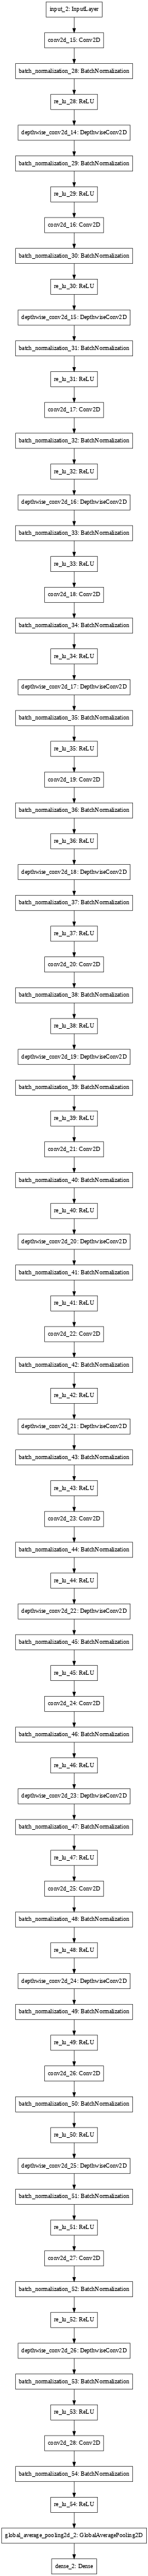

In [ ]:
# TODO Make this better

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

plot_model(model,to_file="custom_mobilenet.png", rankdir='TB', dpi=50)

In [ ]:
# plot_model(model_keras, to_file="keras_mobilenet.png", rankdir='TB', show_layer_names = True, expand_nested=True, dpi=50)

In [ ]:
# Overfitting setup
# from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystop = EarlyStopping(patience=10)

# learning rate change after accuracy stalls
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

callbacks = [earlystop, learning_rate_reduction]

# Train the Model

* [How to interpret “loss” and “accuracy” for a machine learning model](https://stackoverflow.com/questions/34518656/how-to-interpret-loss-and-accuracy-for-a-machine-learning-model)

Using DenseNet (custom implementation)

In [ ]:
# model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['acc'])
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['acc'])
epochs = EPOCH_QUICK if QUICK_TRAIN else EPOCH_NORMAL

# todo: depreciated and should change to Model.fit when we have time
history = model.fit_generator(
    train_generator,
    # samples_per_epoch=TRAINING_SAMPLES, # depreciated from keras 1 api?
    epochs = epochs,
    validation_data = valid_generator,
    validation_steps =  total_dfValidation // BATCH_SIZE,
    steps_per_epoch = total_dfValidation // BATCH_SIZE,
    # callbacks = [checkpointer] #if using keras Mobilenet
    callbacks = callbacks
)

Epoch 1/15
625/625 [==============================] - 60s 95ms/step - loss: 0.8174 - acc: 0.5268 - val_loss: 0.6218 - val_acc: 0.5496
Epoch 2/15
625/625 [==============================] - 54s 87ms/step - loss: 0.7163 - acc: 0.5404 - val_loss: 0.5731 - val_acc: 0.5768
Epoch 3/15
625/625 [==============================] - 54s 87ms/step - loss: 0.6975 - acc: 0.5708 - val_loss: 0.4179 - val_acc: 0.5240
Epoch 4/15
625/625 [==============================] - 54s 86ms/step - loss: 0.6860 - acc: 0.5796 - val_loss: 0.8313 - val_acc: 0.5712

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 5/15
625/625 [==============================] - 54s 86ms/step - loss: 0.6547 - acc: 0.6112 - val_loss: 0.9582 - val_acc: 0.6160
Epoch 6/15
625/625 [==============================] - 54s 87ms/step - loss: 0.6619 - acc: 0.5988 - val_loss: 1.3240 - val_acc: 0.5708
Epoch 7/15
625/625 [==============================] - 54s 87ms/step - loss: 0.6596 - acc: 0.6080 - val_loss: 0.6664

## Feature Visualizations

Visualize the model's trained filters

* [Official Keras : Visualizing what convnets learn](https://keras.io/examples/vision/visualizing_what_convnets_learn/)
* [How convolutional neural networks see the world](https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html)
* [Kernel Visualizations](https://github.com/raghakot/keras-vis)
* [Tools to design/visualize NN architecture](https://github.com/ashishpatel26/Tools-to-Design-or-Visualize-Architecture-of-Neural-Network)
* [Gradient Ascent](https://stackoverflow.com/questions/22594063/what-is-the-difference-between-gradient-descent-and-gradient-ascent)


In [ ]:
# # ref : https://keras.io/examples/vision/visualizing_what_convnets_learn/

# totalLayers = len(model.layers)
# print("Total layers in model: " + str(totalLayers))

# # setup gradient ascent process
# def compute_loss(input_image, filter_index):
#     layer_name = str(model.get_layer(index = filter_index).name)
#     print("Plotting Layer = " + str(layer_name))
#     # Set up a model that returns the activation values for our target layer
#     layer = model.get_layer(name=layer_name)
#     feature_extractor = Model(inputs=model.inputs, outputs=layer.output)
#     activation = feature_extractor(input_image)
#     # We avoid border artifacts by only involving non-border pixels in the loss.
#     filter_activation = activation[:, 2:-2, 2:-2, filter_index]
#     return tf.reduce_mean(filter_activation)

# @tf.function
# def gradient_ascent_step(img, filter_index, learning_rate):
#     with tf.GradientTape() as tape:
#         tape.watch(img)
#         loss = compute_loss(img, filter_index)
#     # Compute gradients.
#     grads = tape.gradient(loss, img)
#     # Normalize gradients.
#     grads = tf.math.l2_normalize(grads)
#     img += learning_rate * grads
#     return loss, img

# # setup end to end filter visualization loop

# def initialize_image():
#     # We start from a gray image with some random noise
#     img = tf.random.uniform((1, IMAGE_WIDTH, IMAGE_LENGTH, 3))
#     # ResNet50V2 expects inputs in the range [-1, +1].
#     # Here we scale our random inputs to [-0.125, +0.125]
#     return (img - 0.5) * 0.25


# def visualize_filter(filter_index):
#     # We run gradient ascent for 20 steps
#     iterations = 30
#     learning_rate = 10.0
#     img = initialize_image()
#     for iteration in range(iterations):
#         loss, img = gradient_ascent_step(img, filter_index, learning_rate)

#     # Decode the resulting input image
#     img = deprocess_image(img[0].numpy())
#     # return loss, img
#     return img


# def deprocess_image(img):
#     # Normalize array: center on 0., ensure variance is 0.15
#     img -= img.mean()
#     img /= img.std() + 1e-5
#     img *= 0.15

#     # Center crop
#     img = img[15:-15, 15:-15, :]

#     # Clip to [0, 1]
#     img += 0.5
#     img = numpy.clip(img, 0, 1)

#     # Convert to RGB array
#     img *= 255
#     img = numpy.clip(img, 0, 255).astype("uint8")
#     return img

# from IPython.display import Image, display
# from keras import preprocessing
# import math

# all_imgs = []

# def isqrt(n):
#     x = n
#     y = (x + 1) // 2
#     while y < x:
#         x = y
#         y = (x + n // x) // 2
#     return x

# min = 0
# max = totalLayers
# print("Plotting Layer Ranges : [" + str(min) + " ," + str(max) + "]")
# for filter_index in range(min, max):
#     try:
#       img = visualize_filter(filter_index)
#       all_imgs.append(img)
#     except:
#      pass


# totalAllImages = len(all_imgs)
# # print("Count of all_imgs = "+ str(len(all_imgs)))

# print("Plottable filters found without errors : " + str(totalAllImages) + " filters.")
# import matplotlib.gridspec as gridspec
# import math

# # https://stackoverflow.com/questions/41071947/how-to-remove-the-space-between-subplots-in-matplotlib-pyplot
# def plotFilters(images_arr):

#   def isqrt(n):
#     x = n
#     y = (x + 1) // 2
#     while y < x:
#         x = y
#         y = (x + n // x) // 2
#     return x

#   totalAllImages = len(images_arr)

#   ncol = isqrt(totalAllImages)
#   nrow = math.ceil(totalAllImages / ncol)
#   print("Generating Grid [" + str(nrow) + ", " + str(ncol) + "]")

#   # increase size here
#   adapt = 250
  
#   fig = plt.figure(figsize=(ncol+adapt, nrow+adapt)) 

#   gs = gridspec.GridSpec(nrow, ncol,
#           wspace=0.0, hspace=0.0, 
#           top=1.-0.5/(nrow+adapt), bottom=0.5/(nrow+adapt), 
#           left=0.5/(ncol+adapt), right=1.-0.5/(ncol+adapt)) 
  
#   gen = iter(images_arr)
#   currentIteration = 0

#   for i in range(nrow):
#       for j in range(ncol):
#           currentIteration += 1
#           ax= plt.subplot(gs[i,j])
#           ax.title.set_text('Filter #' + str(currentIteration))
#           ax.imshow(next(gen, numpy.full((1, 1, 3), 255)))
#           ax.axis('off')
#   # savefig needs to be called before show() otherwise it is freed from mem
#   plt.title("Visualizing filters")
#   plt.savefig('all_filters.png')
#   plt.show()
#   plt.close()
  

# plotFilters(all_imgs)


# Model Accuracy and Loss graphs

In [ ]:
# ref  : https://github.com/IResearchAI/Tobacco_Leaves_Classification_CNN/blob/master/Tob_main2.ipynb

# this is outdated. revert to model.evaluate if possible
loss, accuracy = model.evaluate_generator(valid_generator, 
                                          total_dfValidation // BATCH_SIZE, 
                                          workers=12, 
                                          use_multiprocessing = True)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))




Test: accuracy = 0.737600  ;  loss = 0.772832 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


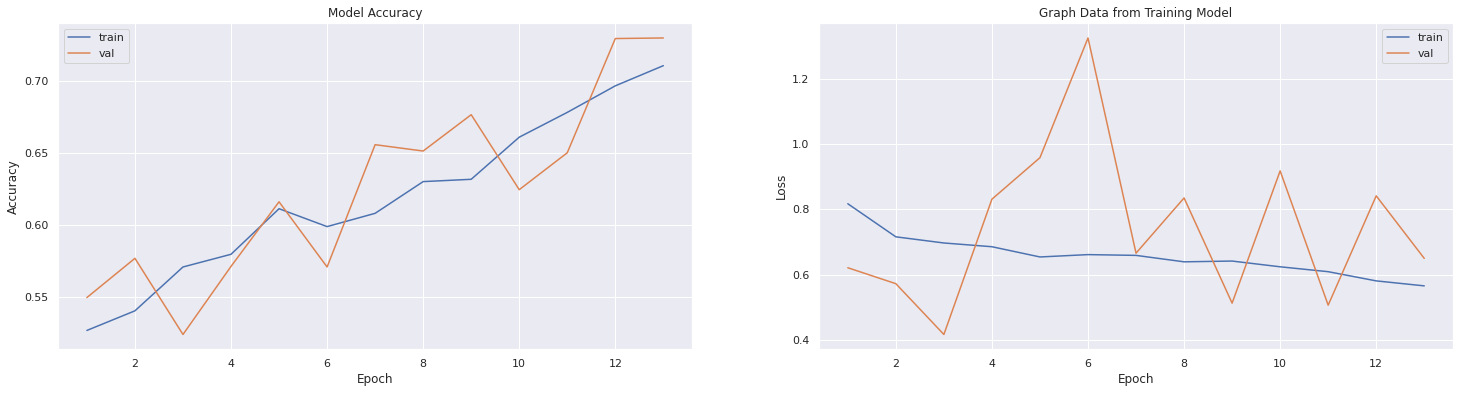

In [ ]:
def plot_model_history(model_history, accuracy='acc', val_accuracy='val_acc'):
    length = 25
    height = 6
    fig, axs = plt.subplots(1,2,figsize=(length,height))
    axs[0].plot(range(1,len(model_history.history[accuracy])+1),model_history.history[accuracy])
    axs[0].plot(range(1,len(model_history.history[val_accuracy])+1),model_history.history[val_accuracy])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(numpy.arange(1,len(model_history.history[accuracy])+1),len(model_history.history[accuracy])/10)
    axs[0].legend(['train', 'val'], loc='best')
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(numpy.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.title("Graph Data from Training Model")
    plt.savefig('accu_loss_graph.png')
    plt.show()
    
plot_model_history(history)


# Confusion Matrix

A [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) is a table that is often used to describe the performance of a classification model (or “classifier”) on a set of test data for which the true values are known. 

Cats = 1, Dogs = 0
1-1 : True Pos (Correct Prediction it's a cat)
1-0 : False Pos (Incorrect Prediction it's a cat)


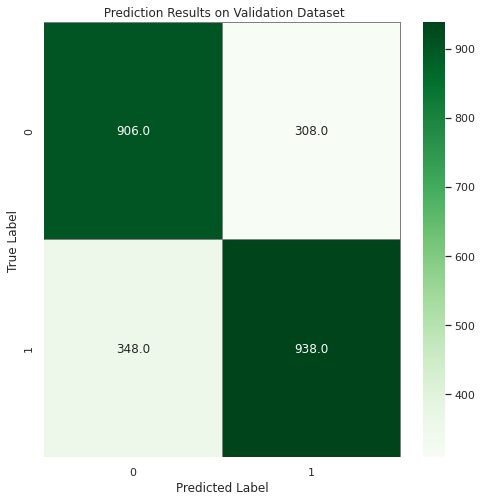

              precision    recall  f1-score   support

           0       0.72      0.75      0.73      1214
           1       0.75      0.73      0.74      1286

    accuracy                           0.74      2500
   macro avg       0.74      0.74      0.74      2500
weighted avg       0.74      0.74      0.74      2500



In [ ]:
# https://gist.github.com/RyanAkilos/3808c17f79e77c4117de35aa68447045
# https://towardsdatascience.com/decoding-the-confusion-matrix-bb4801decbb

from sklearn.preprocessing import MultiLabelBinarizer

valid_generator.reset()
Y_pred =  model.predict_generator(valid_generator)
# argmax : https://datascience.stackexchange.com/questions/45833/keras-model-only-predicts-one-class-for-all-the-test-images
y_pred = numpy.argmax(Y_pred, axis=1)

import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


print("Cats = 1, Dogs = 0")
print("1-1 : True Pos (Correct Prediction it's a cat)")
print("1-0 : False Pos (Incorrect Prediction it's a cat)")
confusion_mtx = confusion_matrix(valid_generator.classes, y_pred)
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(" Prediction Results on Validation Dataset")
plt.show()
print(classification_report(valid_generator.classes, y_pred))

In [ ]:
df_testData = pandas.DataFrame({
    'filename': testingDataset
})

dg_testing = ImageDataGenerator(
    rescale = 1./255,
)

tests_generator = dg_testing.flow_from_dataframe(
    df_testData, 
    directory = testingData_dir, 
    x_col = 'filename',
    y_col = None,
    # class_mode = 'binary',
    class_mode = None,
    target_size = (IMAGE_WIDTH, IMAGE_LENGTH),
    batch_size = BATCH_SIZE,
    shuffle = False,
)

prediction =  model.predict_generator(tests_generator, steps=numpy.ceil(df_testData.shape[0]/BATCH_SIZE))


Found 12500 validated image filenames.


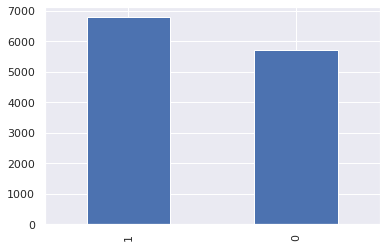

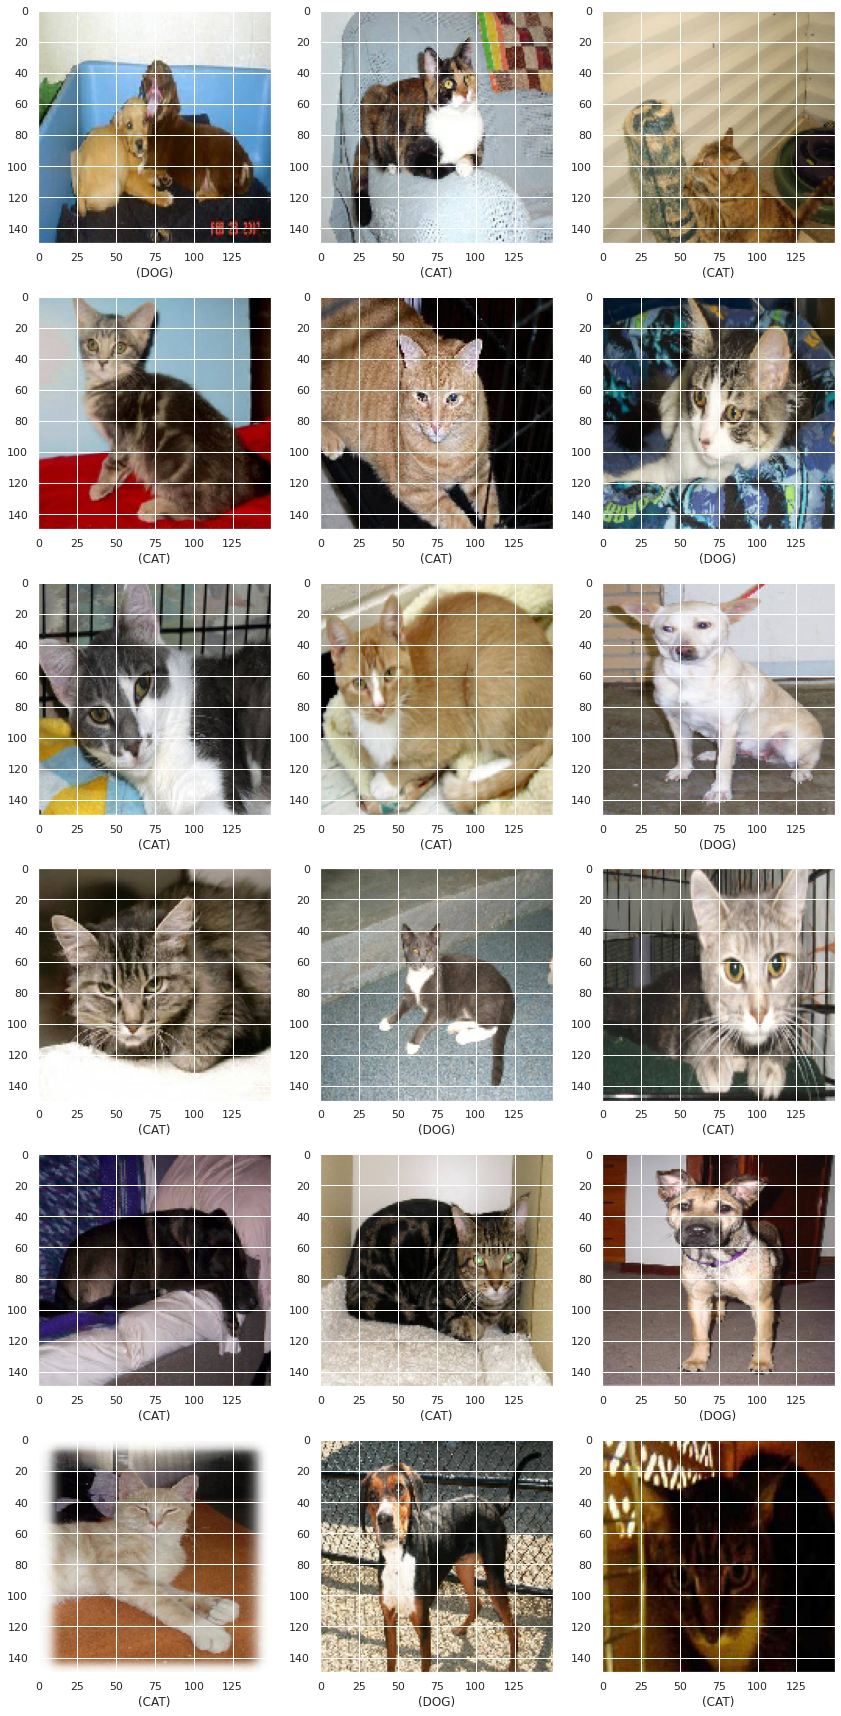

In [ ]:
df_testData['category'] = numpy.argmax(prediction, axis=-1)
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
df_testData['category'] = df_testData['category'].replace(label_map)
df_testData['category'] = df_testData['category'].replace({ 'dog': 1, 'cat': 0 })
df_testData['category'].value_counts().plot.bar()

sample_test = df_testData.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img(testingData_dir+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    if (category == 1):
      result = str('DOG')
    else:
      result = str('CAT')
    plt.xlabel('(' + result + ')')
plt.tight_layout()
plt.show()